In [39]:
#Variational autoencoder
import tensorflow as tf
import tensorflow.contrib.layers as tfl
import numpy as np
import matplotlib.pyplot as plt
tf.reset_default_graph()

In [40]:
#setup input data

from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='/home/ubuntu/')
xs=mnist.data*1.0/255.0


(70000, 28, 28)


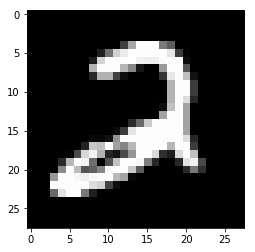

In [41]:
img =np.reshape(mnist.data,[-1,28,28])
print(img.shape)
plt.imshow(img[15000],cmap="gray")
plt.show()

In [42]:
encode_layer_array=[50,50,50,50]
batch_size=50
num_latents=20
def encode(inputX,layer_array,activation_fn=tf.nn.relu,scope="encoding"):
    for i,lyr in enumerate(layer_array):
        output=tfl.fully_connected(inputX,lyr,activation_fn=activation_fn)
        inputX=output
        if i==len(encode_layer_array)-1:
            x_means=tfl.fully_connected(inputX,num_latents,activation_fn=activation_fn)
            x_stds=tfl.fully_connected(inputX,num_latents,activation_fn=activation_fn)
    return x_means,x_stds


def decode(inputX,layer_array,activation_fn=tf.nn.relu,scope="decoding"):
    for i,lyr in enumerate(layer_array):
        output=tfl.fully_connected(inputX,lyr,activation_fn=activation_fn)
        inputX=output
        if i==len(encode_layer_array)-1:
            output=tfl.fully_connected(inputX,mnist.data.shape[1],activation_fn=tf.nn.sigmoid)
    return output

In [43]:

X=tf.placeholder(dtype=tf.float32,shape=[batch_size,mnist.data.shape[1]])
#Y=tf.placeholder(dtype=tf.float32,shape=[batch_size,mnist.data.shape[1]])
z_mean,z_stddev=encode(X,encode_layer_array)
rands=np.random.randn(num_latents)
sampled_rands=z_mean+z_stddev*rands

encode_output=encode(X,encode_layer_array)

Y=decode(encode_output,encode_layer_array[::-1])

kl_loss=0.5 * tf.reduce_sum(tf.square(z_mean) + tf.square(z_stddev) - tf.log(tf.square(z_stddev)+1e-8) - 1,1)

print(kl_loss.shape)
recon_loss= -tf.reduce_sum(tf.reduce_sum(X * tf.log(1e-8 + Y) + (1-X) * tf.log(1e-8 + 1 - Y),0),1)
print(recon_loss.shape)
total_loss=tf.reduce_mean(kl_loss+recon_loss)

optimizer=tf.train.AdamOptimizer(.001).minimize(total_loss)



(50,)
(50,)


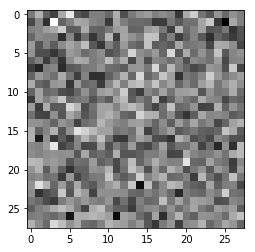

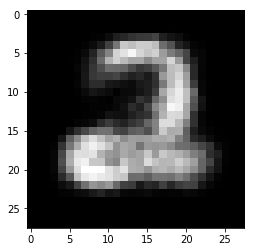

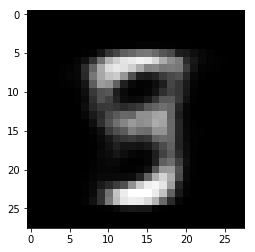

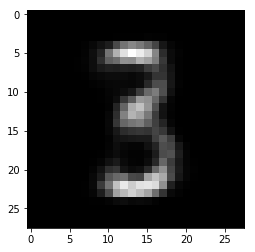

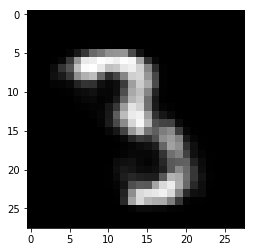

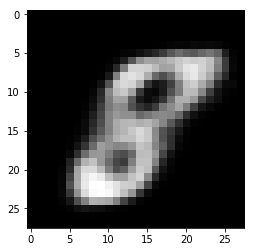

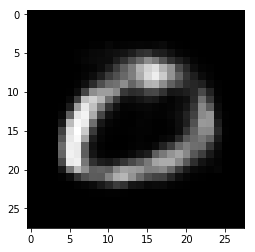

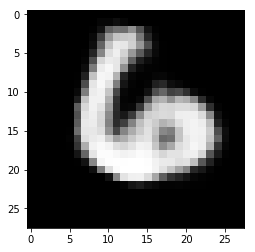

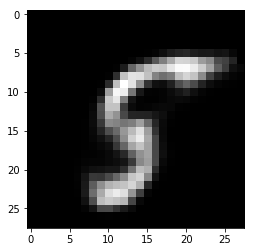

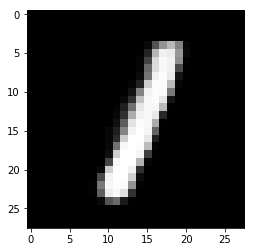

In [38]:
n_epochs=10000
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_epochs):
        xs_batch=xs[np.random.randint(0,mnist.data.shape[0]-1,batch_size),:]
        #print(xs_batch)
        sess.run(optimizer,feed_dict={X:xs_batch})
        #print(sess.run(total_loss,feed_dict={X:xs_batch}))
        if i % 1000==0:
            img_arr=sess.run(Y,feed_dict={X:xs_batch})
            img_resh=np.reshape(img_arr,[-1,28,28])
            #print(img_resh.shape)
            plt.imshow(img_resh[0,:,:],cmap="gray")
            plt.show()
    